## <div align="center"> Movies Recommender </div>
***

This notebook aims to show the basics of building a movie Recommender and with the emphasis of how the business ideas are built through Data Analytics, especially in traditional quantitative techniques (e.g. Hypothesis Testing). In this example, MovieLens 100K Dataset (for more details on the data fields definition [here](https://www.tensorflow.org/datasets/catalog/movielens#top_of_page)) will be used and the sections of this study are divided as following:

1. [Environment Setup:](#environment_setup_movie) import libraries, load and prepare datasets

2. [Exploratory Data Analysis:](#eda)

    2.1. [Univariate Analysis](#uni_analysis)
    
    2.2. [Bivariate Analysis](#bi_analysis)

    2.3. [Multivariate Analysis (Two-way ANOVA)](#multi_analysis) 

3. [k-Nearest Neighbors Recommendation System](#knn)

4. [Wrap Up:](#wrap_up_movie) Discussion & Closing

<br>
<br>

### 1. Environment Setup <a id='environment_setup_movie'></a> 

[Sections](#sections-movie)

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="whitegrid")

import tensorflow as tf
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
ratings = tfds.load('movielens/100k-ratings', split='train')
movies = tfds.load('movielens/100k-movies', split='train')

In [3]:
# data cleaning: from dictionary to dataframe
df_ratings = tfds.as_dataframe(ratings.take(len(list(ratings))))
df_movies = tfds.as_dataframe(movies.take(len(list(movies))))

In [4]:
# check data shape
print('ratings df shape : ', df_ratings.shape)
print('movies df shape: ', df_movies.shape)

ratings df shape :  (100000, 12)
movies df shape:  (1682, 3)


In [5]:
# check ratings dataframe
df_ratings.head(1)

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'


In [6]:
# check movies dataframe
df_movies.head(3)

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,"[4, 7]",b'1457',b'Love Is All There Is (1996)'
2,"[1, 3]",b'500',b'Fly Away Home (1996)'


##### **Observation 1 (so far)

the movies dataset seems like a subset of the ratings table, which means the movies dataset do not provide any additional information and hence, **this movie dataset will be dropped** for the subsequent analysis.

##### Data Preparation

In [7]:
# check data types & missing values
df_ratings.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float64
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float64
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float64
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB


##### **Observation 2 (so far)

Generally, the data seems clean, such as there is no missing value to worry about, the data types are generally presented at the right format to perform the analysis that intends to cover in this notebook.

### 2. Exploratory Data Analysis<a id='eda'></a> 

[Sections](#sections-movie)

Let's start with Summary Statistics.

In [8]:
df_ratings.describe(datetime_is_numeric=True)

,bucketized_user_age,raw_user_age,timestamp,user_occupation_label,user_rating
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,29.235460,32.969850,8.835289e+08,11.404320,3.529860
std,12.005927,11.562623,5.343856e+06,6.549283,1.125674
min,1.000000,7.000000,8.747247e+08,0.000000,1.000000
25%,18.000000,24.000000,8.794487e+08,6.000000,3.000000
50%,25.000000,30.000000,8.828269e+08,12.000000,4.000000
75%,35.000000,40.000000,8.882600e+08,17.000000,4.000000
max,56.000000,73.000000,8.932866e+08,21.000000,5.000000


##### **Observation 3 (so far)

The key idea of having the Summary Statistics above is to gain a quick view of how the data spreads across. Certainly, more information is needed in order to interpret the result, for instance, the row of "min" shows "1" under "bucketized_user_age" column, without understanding the numeric representation, it might give a false sense that the data contains some noise (e.g. "1" = 1 year old). However, "1" is a label for under 18 age group bucket in this dataset.

#### 2.1. Univariate Analysis<a id='uni_analysis'></a> 

[Sections](#sections-movie)

Let's take a closer look from the users' perspective (e.g. gender, occupation etc).

In [9]:
# user_gender : True = Male; otherwise = Female
df_ratings.user_gender = df_ratings.user_gender.map({True: 'Male', False: 'Female'})

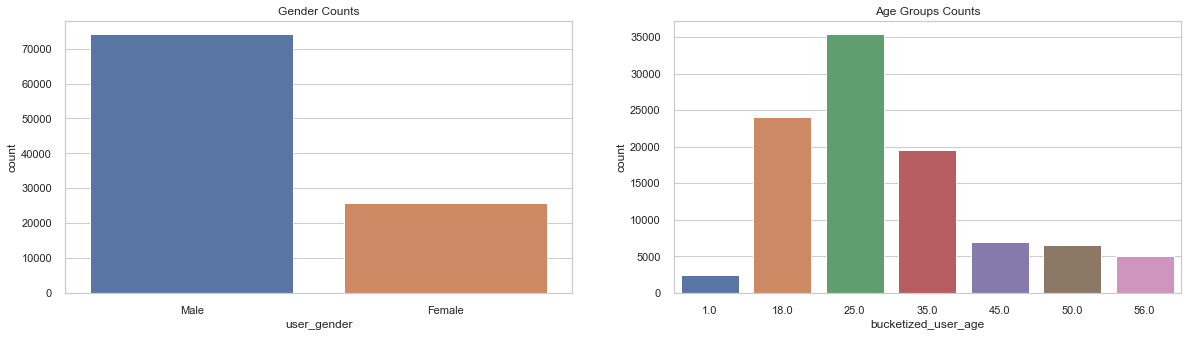

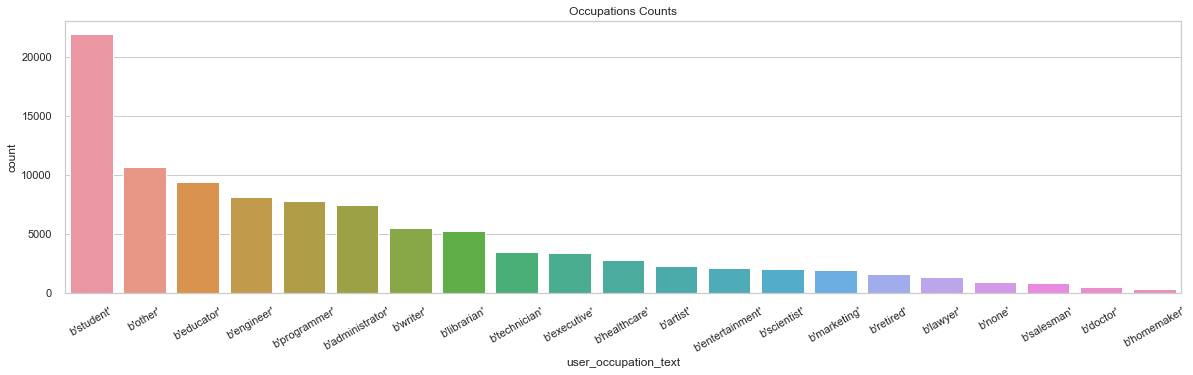

In [10]:
# gender & age bucket overview
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(ax=ax[0], data=df_ratings, x='user_gender')
sns.countplot(ax=ax[1], data=df_ratings, x='bucketized_user_age')
ax[0].set_title("Gender Counts")
ax[1].set_title("Age Groups Counts")

# occupation overview
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.countplot(data=df_ratings, x='user_occupation_text', order=df_ratings.user_occupation_text.value_counts().iloc[:].index)
g.set_title('Occupations Counts')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

##### **Observation 4 (so far)

Generally, the figures above help me to understand most of the users are Male, and their occupations are likely to be students. However, the "bucketized_user_age" figure triggers another question is that, with a high occupation in "student", are the students generaly ages around 25-34? In order to control the flow of this presentation, the question mentioned here will not be further explored but to share how more ideas are formed, and may be dropped due to more findings will discover one and another. Regardless, the key takeaway in these plottings is to gain an overview about the users' background.

#### 2.2. Bivariate Analysis<a id='bi_analysis'></a> 

[Sections](#sections-movie)

The goal of this section is to demo a simple analysis that only covers 2 variables.

In the following example, this analysis **(business logic)** attempts to find out if the popularity of a movie is due to a good storyline or just purely because of its fame (e.g. must watch because a famous actor, parts of Marvel Comics or other factors). In order to translate this logic on what is available from the given data, "user_rating" will be used as a feature to represent if the movie had "a good storyline"; while "the number of views" will be used as a way to tell the popularity of a movie in this study. 

In [11]:
# group movies by counting views, averaging user rating
group_movies_view_rating = df_ratings.groupby(['movie_title']).agg({'movie_title': ['count'], 'user_rating': ['mean']})

# rename the groupby columns
group_movies_view_rating.columns = group_movies_view_rating.columns.droplevel(0)

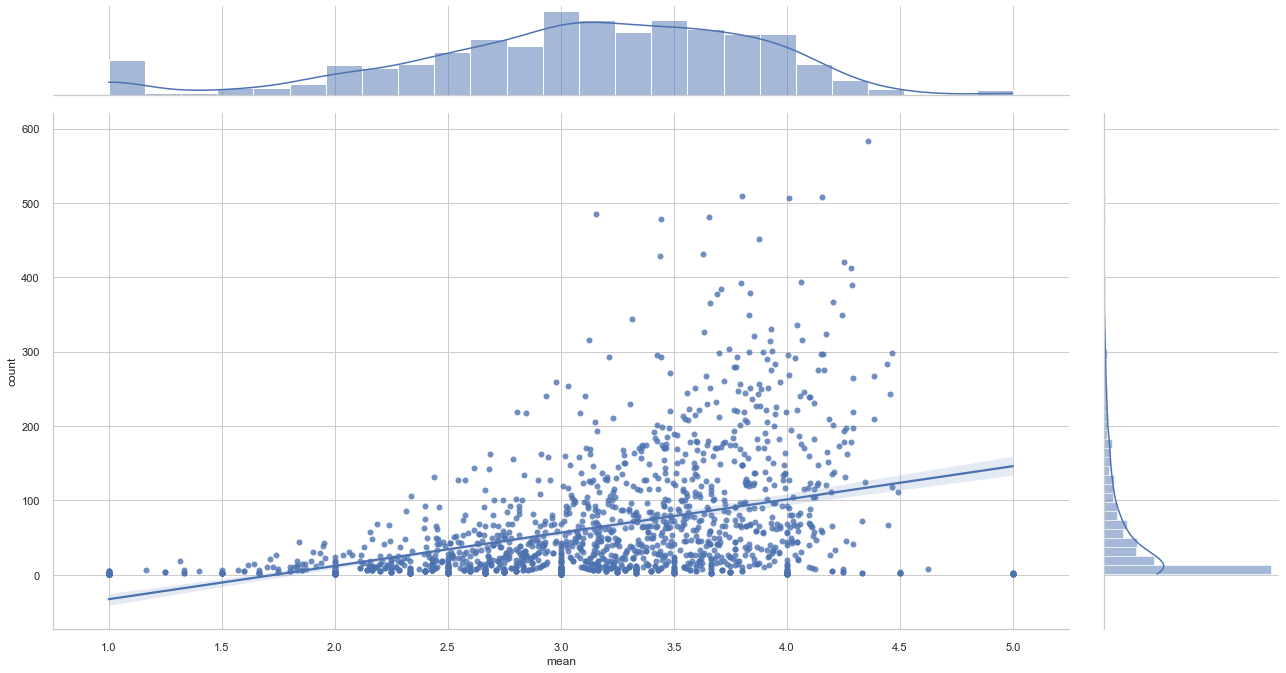

In [12]:
g = sns.jointplot(data=group_movies_view_rating, x='mean', y='count', kind="reg")
g.fig.set_size_inches(20,10)

##### Result Interpretation (jointplot)

The plots above aims to investigate if a more-viewed movie would gain a higher rating. The regression plot (the figure with x & y axis labels) aims to prove that the numbers of views and the ratings should not be treated as linearly dependent, and might involves more variables and considerations to support the business idea. Having said that, the most viewed movie tends to gain a fairly high rating on average, which implies that most likely the movie will be highly recommended regardless the individuals' preferences. The distribution plot on the right hand side indicates how the data from the numbers of views disperse; while the distribution plot on the top show the spread of the ratings. Putting these 2 distributions together, it indirectly tells that the quality of the Movies is generally on averaged, which means that most of the Movies in the collection is just "fine" to watch rather than a must-watch movie.

#### 2.3. Multivariate Analysis (Two-way ANOVA)<a id='multi_analysis'></a> 

[Sections](#sections-movie)

This section will focus on an example of Hypothesis Testing - Analysis of Variance (ANOVA).  

The goal of this study is to understand if gender and occupation affected on the ratings, and what are their interactions. One of the **arguments** behind this analysis is that, users' ratings may be varied due to their personal experience or exposure. To quantify this argument, "user_gender" and "user_occupation_text" will be used as a set of features in this study.

In [13]:
# ols = ordinary least squares
model_ols = ols('user_rating ~ user_occupation_text + user_gender+user_occupation_text*user_gender', data=df_ratings).fit()
anova = sm.stats.anova_lm(model_ols, type=2)
anova

,df,sum_sq,mean_sq,F,PR(>F)
user_occupation_text,20.0,1887.199587,94.359979,76.234662,5.529671e-309
user_gender,1.0,62.511763,62.511763,50.504071,1.197086e-12
user_occupation_text:user_gender,20.0,1038.449623,51.922481,41.948852,3.986382e-164
Residual,99959.0,123724.942380,1.237757,NaN,NaN


##### Result Interpretation (Two-way ANOVA)

The ANOVA table above shows the statistics used to test hypotheses of the population means, which provides a general assessment of a statistical difference in more than 2 independent means. The key takeaway from the ANOVA table is the p-value (last column: PR(>F)), which helps to decide if a factor is likely affecting the dependent variable. 

In this case, the p-values of the first two rows with less than 0.05 (a typical threshold for comparison), indicate that each predictor (occupation and gender) do affect the ratings decision. In addition, the p-value from the third row shows the interaction between occupation and gender is lower than the p level of significance (0.05) and hence, their correlation is statistically significant. In the layman terms, the ratings vary across individuals do because of the difference in both gender and occupation.

##### **Observation 5 (so far)

Putting all analyses together, the ratings are affected by many different factors, which the findings so far, suggest that more analysis needed or rethink about the business questions or objectives. Regardless, these analytics help to understand how the insights could be extracted from the dataset, and the next section is designed partly to answer the questions prompted here.

### 3. k-Nearest Neighbors Recommendation System<a id='knn'></a>

[Sections](#sections-movie)

This section aims to share one of the user-based Collaborative Filtering techniques that is widely used to build a recommendation system. This approach is promising due to its underlying assumptions, which cleverly help reducing the complexity of the problem as well as downsizing the numbers of dimensionality in terms of a mathematical point of view. For more details about the explanation of the underlying assumptions can be found [here](https://en.wikipedia.org/wiki/Collaborative_filtering).

In [14]:
# create matrix with movies
table_cf = df_ratings.pivot(index='movie_id', columns='user_id', values='user_rating').fillna(0)
mat_movies_users = csr_matrix(table_cf.values)

In [15]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute', n_neighbors = 20)

In [16]:
# fit model
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                 radius=1.0)

In [17]:
# Recommender(movie_title) > List of Movies recommended
def recommender(movie_title, dataframe, model, return_searched_results):
    
    model.fit(dataframe)
    idx = process.extractOne(movie_title, df_ratings.movie_title)[2]
    distances, indices = model.kneighbors(dataframe[idx], n_neighbors = return_searched_results+1)
    for ind in indices:
        movielist = df_ratings.movie_title[ind].where(ind!=idx)
        
    return movielist

The following code does require you to define the inputs for further testing.

In [18]:
# set your inputs
movie_name_input = 'star wars'
num_return_results = 5
recommended_movie_list = recommender(movie_name_input, mat_movies_users, model_knn, num_return_results)

In [19]:
print('\n\nThe list of recommended Movies\n')
recommended_movie_list.dropna().to_frame().reset_index(drop=True)



The list of recommended Movies



,movie_title
0,"b'Net, The (1995)'"
1,b'Grumpier Old Men (1995)'
2,"b'Nightmare Before Christmas, The (1993)'"
3,b'Multiplicity (1996)'
4,b'Up Close and Personal (1996)'


### 4. Wrap Up<a id='wrap_up_movie'></a>

[Sections](#sections-movie)

**Discussion & Closing:**

Undoubtedly, the business ideas would not be built strictly follow the steps of Univariate, Bivariate, or Multivariate analysis in the reality, but rather depend on the suitability of the method at that time in order to support the business arguments, logic, assumptions, or hypotheses. Also, the relationship between variables are so complex that will require clustering / ML / DL techniques to help discovering the patterns or the data relationships. Together with the current Big Data trend, traditional analytics must evolve and leverage on the modern technology (incl. advanced techniques such as Machine Learning &. Deep Learning). Having said that, being able to ask the relevant questions do help to overcome many limitations after all, for instance, the underlying assumptions made on: using Collaborative Filtering to build Recommendation System, have creatively turned a complex modeling into a matrix-based solution.     

To sum up, the goal of this notebook is to demo how to build a basic movie recommender and how the data analytics is used to support business ideas. Hopefully, this brief presentation gives you some ideas on my skill sets in general. Once again, thank you for considering me.